In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import nltk
import string
from gensim import corpora, models
import re
import matplotlib.pyplot as plt
import json
from sklearn.manifold import TSNE

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets') 
nltk.download('stopwords')
nltk.download('wordnet')

## Scrape links

In [7]:
html = requests.get("https://fangj.github.io/friends")
soup = BeautifulSoup(html.text, "html.parser") # get the HTML of the main page to scrape all the links
print(soup.prettify())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">
<html>
 <head>
  <title>
   Friends Transcripts
  </title>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
 </head>
 <body>
  <h3>
   SEASON 1
  </h3>
  <ul>
   <li>
    <a href="season/0101.html">
     101  Monica Gets A Roommate
    </a>
   </li>
   <li>
    <a href="season/0102.html">
     102  The Sonogram At The End
    </a>
   </li>
   <li>
    <a href="season/0103.html">
     103  The Thumb
    </a>
   </li>
   <li>
    <a href="season/0104.html">
     104  George Stephanopoulos
    </a>
   </li>
   <li>
    <a href="season/0105.html">
     105  The East German Laundry Detergent
    </a>
   </li>
   <li>
    <a href="season/0106.html">
     106  The Butt
    </a>
   </li>
   <li>
    <a href="season/0107.html">
     107  The Blackout
    </a>
   </li>
   <li>
    <a href="season/0108.html">
     108  Nana Dies Twice
    </a>
   </li>
   <li>
    <a href="season/0109.html">
     109  Underdog G

In [8]:
# because of the way the HTML of the website is set up, each season is under a different <ul> item, so first I am going to find all of these
first_anchors = soup.find_all('ul')
first_anchors[0]

<ul>
<li><a href="season/0101.html">101  Monica Gets A Roommate </a></li>
<li><a href="season/0102.html">102  The Sonogram At The End </a></li>
<li><a href="season/0103.html">103  The Thumb </a></li>
<li><a href="season/0104.html">104  George Stephanopoulos </a></li>
<li><a href="season/0105.html">105  The East German Laundry Detergent </a></li>
<li><a href="season/0106.html">106  The Butt </a></li>
<li><a href="season/0107.html">107  The Blackout </a></li>
<li><a href="season/0108.html">108  Nana Dies Twice </a></li>
<li><a href="season/0109.html">109  Underdog Gets Away </a></li>
<li><a href="season/0110.html">110  The Monkey </a></li>
<li><a href="season/0111.html">111  Mrs. Bing </a></li>
<li><a href="season/0112.html">112  The Dozen Lasagnas </a></li>
<li><a href="season/0113.html">113  The Boobies </a></li>
<li><a href="season/0114.html">114  The Candy Hearts </a></li>
<li><a href="season/0115.html">115  The Stoned Guy </a></li>
<li><a href="season/0116.html">116  The Two Parts, 

In [9]:
# now, for each <ul>, I will find all the "a" items
second_anchors = [i.find_all('a') for i in first_anchors]
second_anchors

[[<a href="season/0101.html">101  Monica Gets A Roommate </a>,
  <a href="season/0102.html">102  The Sonogram At The End </a>,
  <a href="season/0103.html">103  The Thumb </a>,
  <a href="season/0104.html">104  George Stephanopoulos </a>,
  <a href="season/0105.html">105  The East German Laundry Detergent </a>,
  <a href="season/0106.html">106  The Butt </a>,
  <a href="season/0107.html">107  The Blackout </a>,
  <a href="season/0108.html">108  Nana Dies Twice </a>,
  <a href="season/0109.html">109  Underdog Gets Away </a>,
  <a href="season/0110.html">110  The Monkey </a>,
  <a href="season/0111.html">111  Mrs. Bing </a>,
  <a href="season/0112.html">112  The Dozen Lasagnas </a>,
  <a href="season/0113.html">113  The Boobies </a>,
  <a href="season/0114.html">114  The Candy Hearts </a>,
  <a href="season/0115.html">115  The Stoned Guy </a>,
  <a href="season/0116.html">116  The Two Parts, Part I </a>,
  <a href="season/0117.html">117  The Two Parts, Part II </a>,
  <a href="season/011

In [10]:
# unlist second_anchors because each set of season links is a sublist within the big list
flat_anchors = [item for sublist in second_anchors for item in sublist]
flat_anchors

[<a href="season/0101.html">101  Monica Gets A Roommate </a>,
 <a href="season/0102.html">102  The Sonogram At The End </a>,
 <a href="season/0103.html">103  The Thumb </a>,
 <a href="season/0104.html">104  George Stephanopoulos </a>,
 <a href="season/0105.html">105  The East German Laundry Detergent </a>,
 <a href="season/0106.html">106  The Butt </a>,
 <a href="season/0107.html">107  The Blackout </a>,
 <a href="season/0108.html">108  Nana Dies Twice </a>,
 <a href="season/0109.html">109  Underdog Gets Away </a>,
 <a href="season/0110.html">110  The Monkey </a>,
 <a href="season/0111.html">111  Mrs. Bing </a>,
 <a href="season/0112.html">112  The Dozen Lasagnas </a>,
 <a href="season/0113.html">113  The Boobies </a>,
 <a href="season/0114.html">114  The Candy Hearts </a>,
 <a href="season/0115.html">115  The Stoned Guy </a>,
 <a href="season/0116.html">116  The Two Parts, Part I </a>,
 <a href="season/0117.html">117  The Two Parts, Part II </a>,
 <a href="season/0118.html">118  All T

In [11]:
# get all the links for each episode
links = ["https://fangj.github.io/friends/" + i.get('href') for i in flat_anchors]
links

['https://fangj.github.io/friends/season/0101.html',
 'https://fangj.github.io/friends/season/0102.html',
 'https://fangj.github.io/friends/season/0103.html',
 'https://fangj.github.io/friends/season/0104.html',
 'https://fangj.github.io/friends/season/0105.html',
 'https://fangj.github.io/friends/season/0106.html',
 'https://fangj.github.io/friends/season/0107.html',
 'https://fangj.github.io/friends/season/0108.html',
 'https://fangj.github.io/friends/season/0109.html',
 'https://fangj.github.io/friends/season/0110.html',
 'https://fangj.github.io/friends/season/0111.html',
 'https://fangj.github.io/friends/season/0112.html',
 'https://fangj.github.io/friends/season/0113.html',
 'https://fangj.github.io/friends/season/0114.html',
 'https://fangj.github.io/friends/season/0115.html',
 'https://fangj.github.io/friends/season/0116.html',
 'https://fangj.github.io/friends/season/0117.html',
 'https://fangj.github.io/friends/season/0118.html',
 'https://fangj.github.io/friends/season/0119.

## Scrape script from each episode

In [12]:
# create list of htmls from links
htmls = [requests.get(i) for i in links]
# create list of soups - each item in list is full html for one episode
soups = [BeautifulSoup(i.text, "html.parser") for i in htmls]

In [109]:
print(soups[31].prettify()) # let's checkitout

<html>
 <head>
  <title>
   The One With the Last
  </title>
 </head>
 <body alink="yellow" bgcolor="white" link="green" text="black" vlink="black">
  <h1 align="center">
   The One With the List
  </h1>
  <hr align="center"/>
  <font size="3">
   <i>
    <p>
     Originally written by Marta Kauffman and David Crane
     <br/>
     Trascribed by Mindy Mattingly Phillips
     <a href="mailto:mmatting@indiana.edu">
      [mmatting@indiana.edu]
     </a>
     <br/>
     Minor additions and adjustments by Dan Silverstein.
     <br/>
    </p>
   </i>
  </font>
 </body>
</html>
<hr/>
<font size="3">
 <p>
  [Scene: Monica and Rachel's apartment. Phoebe, Monica, and Rachel are there, discussing
the night before.]
 </p>
 <p>
  RACH: Ross kissed me.
 </p>
 <p>
  MNCA: Oh my god, oh my god, oh my god!
 </p>
 <p>
  RACH: It was unbelievable!
 </p>
 <p>
  MNCA: Oh my god, oh my god, oh my god!
 </p>
 <p>
  PHOE: Ok, all right. We want to hear everything. Monica, get the wine and unplug the
phone. R

In [110]:
# create the first level of anchors (as above) to find all the <font> items for all the htmls for all seasons
lines = [i.get_text() for i in soups]
print(lines)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
# unlist lines because each episode is a sublist within a big list
flat_lines = [item for sublist in lines for item in sublist]
flat_lines

[<font size="3">
 <p>Written by: Marta Kauffman &amp; David Crane</p></font>,
 <font color="#0000FF">blue</font>,
 <font color="#000000"> text.)</font>,
 <font size="3"><b>
 <p align="left"></p></b>[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]</font>,
 <font size="3"><b>Monica:</b> There's nothing to tell! He's just some guy
 I work with!</font>,
 <font size="3"><b>Joey:</b> C'mon, you're going out with the guy! There's
 gotta be something wrong with him!</font>,
 <font size="3"><b>Chandler:</b> <font color="#0000FF">All right Joey, be
 nice.  </font>So does he have a hump? A hump and a hairpiece?</font>,
 <font color="#0000FF">All right Joey, be
 nice.  </font>,
 <font size="3"><b>Phoebe:</b> Wait, does he eat chalk?</font>,
 <font size="3">(They all stare, bemused.)</font>,
 <font size="3"><b>Phoebe:</b> Just, 'cause, I don't want her to go through
 what I went through with Carl- oh!</font>,
 <font size="3"><b>Monica:</b> Okay, everybody relax. This is not even

In [16]:
# get the text for each line of each episode of each season
list_script = [i.get_text() for i in flat_lines]
list_script

['\nWritten by: Marta Kauffman & David Crane',
 'blue',
 ' text.)',
 '\n[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]',
 "Monica: There's nothing to tell! He's just some guy\nI work with!",
 "Joey: C'mon, you're going out with the guy! There's\ngotta be something wrong with him!",
 'Chandler: All right Joey, be\nnice.\xa0 So does he have a hump? A hump and a hairpiece?',
 'All right Joey, be\nnice.\xa0 ',
 'Phoebe: Wait, does he eat chalk?',
 '(They all stare, bemused.)',
 "Phoebe: Just, 'cause, I don't want her to go through\nwhat I went through with Carl- oh!",
 "Monica: Okay, everybody relax. This is not even a\ndate. It's just two people going out to dinner and- not having sex.",
 'Chandler: Sounds like a date to me.',
 '[Time Lapse]',
 "Chandler: Alright, so I'm back in high school, I'm\nstanding in the middle of the cafeteria, and I realize I am totally naked.",
 'All: Oh, yeah. Had that dream.',
 "Chandler: Then I look down, and I realize there's a\nphone.

Let's move this text into a Pandas df to be able to manipulate it more easily

In [48]:
# pull each line in as a separate row
df = pd.DataFrame(list_script, columns = ["Original"])
df.head(10)

Original
0         \nWritten by: Marta Kauffman & David Crane
1                                               blue
2                                             text.)
3  \n[Scene: Central Perk, Chandler, Joey, Phoebe...
4  Monica: There's nothing to tell! He's just som...
5  Joey: C'mon, you're going out with the guy! Th...
6  Chandler: All right Joey, be\nnice.  So does h...
7                        All right Joey, be\nnice.  
8                   Phoebe: Wait, does he eat chalk?
9                         (They all stare, bemused.)

In [49]:
df["Original"] = df["Original"].str.replace('\n', ' ') # remove new lines
df["Original"] = [re.sub("[\(\[].*?[\)\]]", "", i) for i in df["Original"]] # remove parentheses and bracket content

In [50]:
df = df[df.Original != ""] # remove rows that are empty after removal of bracket content

In [51]:
# since I substituted new lines for a space to separate out words, after removal of bracket 
# content some rows were left with space values - remove these
df = df[df.Original != " "]

In [53]:
df.head(20)

Original
0            Written by: Marta Kauffman & David Crane
1                                                blue
2                                              text.)
4   Monica: There's nothing to tell! He's just som...
5   Joey: C'mon, you're going out with the guy! Th...
6   Chandler: All right Joey, be nice.  So does he...
7                          All right Joey, be nice.  
8                    Phoebe: Wait, does he eat chalk?
10  Phoebe: Just, 'cause, I don't want her to go t...
11  Monica: Okay, everybody relax. This is not eve...
12                Chandler: Sounds like a date to me.
14  Chandler: Alright, so I'm back in high school,...
15                     All: Oh, yeah. Had that dream.
16  Chandler: Then I look down, and I realize ther...
17                               Joey: Instead of...?
18                            Chandler: That's right.
19                        Joey: Never had that dream.
20                                        Phoebe: No.
21  Chandler: All of a sudden, the phone starts to...
22  Now I don't know what to do, everybody starts ...

In [54]:
# turn it all lowercase
df["Original"] = df["Original"].str.lower()

In [56]:
# define a function that returns the string before the colon, which in most cases is the speaker
Speaker = []
def find_speaker(string):
    try: 
        Speaker = re.search('(.+?):', string).group(1)
    except AttributeError: # account for cases where there is no speaker
        Speaker = ""
    return Speaker

In [57]:
# attach Speaker as the second column to the df
df['Speaker'] = df["Original"].apply(find_speaker)

In [58]:
df.head(15) # worked!

Original      Speaker
0            written by: marta kauffman & david crane   written by
1                                                blue             
2                                              text.)             
4   monica: there's nothing to tell! he's just som...       monica
5   joey: c'mon, you're going out with the guy! th...         joey
6   chandler: all right joey, be nice.  so does he...     chandler
7                          all right joey, be nice.               
8                    phoebe: wait, does he eat chalk?       phoebe
10  phoebe: just, 'cause, i don't want her to go t...       phoebe
11  monica: okay, everybody relax. this is not eve...       monica
12                chandler: sounds like a date to me.     chandler
14  chandler: alright, so i'm back in high school,...     chandler
15                     all: oh, yeah. had that dream.          all
16  chandler: then i look down, and i realize ther...     chandler
17                               joey: instead of...?         joey

In [59]:
# now let's define a function that substitutes the speaker with nothing (aka removes it) to get just the line of script
Script = []
def find_script(string):
    try: 
        Script = re.sub('(.+?):', "", string)
    except AttributeError: # again account for lack of speaker
        Script = string
    return Script

In [60]:
# attach as third column to df
df['Script'] = df["Original"].apply(find_script)

In [61]:
df.head(15) # still shocked that I can make the computer bend to my will

Original      Speaker  \
0            written by: marta kauffman & david crane   written by   
1                                                blue                
2                                              text.)                
4   monica: there's nothing to tell! he's just som...       monica   
5   joey: c'mon, you're going out with the guy! th...         joey   
6   chandler: all right joey, be nice.  so does he...     chandler   
7                          all right joey, be nice.                  
8                    phoebe: wait, does he eat chalk?       phoebe   
10  phoebe: just, 'cause, i don't want her to go t...       phoebe   
11  monica: okay, everybody relax. this is not eve...       monica   
12                chandler: sounds like a date to me.     chandler   
14  chandler: alright, so i'm back in high school,...     chandler   
15                     all: oh, yeah. had that dream.          all   
16  chandler: then i look down, and i realize ther...     chandler   
17                               joey: instead of...?         joey   

                                               Script  
0                        marta kauffman & david crane  
1                                                blue  
2                                              text.)  
4    there's nothing to tell! he's just some guy i...  
5    c'mon, you're going out with the guy! there's...  
6    all right joey, be nice.  so does he have a h...  
7                          all right joey, be nice.    
8                            wait, does he eat chalk?  
10   just, 'cause, i don't want her to go through ...  
11   okay, everybody relax. this is not even a dat...  
12                          sounds like a date to me.  
14   alright, so i'm back in high school, i'm stan...  
15                          oh, yeah. had that dream.  
16   then i look down, and i realize there's a pho...  
17                                     instead of...?

# all scrubbed clean - now analyses

## Frequencies of Body Words - Full Series

In [74]:
# create a list of common body image-related terms to look for in the script
words = ["hottie", "sexy", "exercis", "waist", "busty", "fat ", "fatso ", 
         "fatty", "big boned", "big-boned", "flab", "binge", " pig ", "piggy", 
         "pig out", "lard ", "chunky", "weight", "skinny", " thin ", "healthy",
         "athletic", "saggy", "anorexic", "skeletal", "bag of bones", "diet"]

In [75]:
# create a list of compiled patterns to search for the words in "words"
patterns = [re.compile(x) for x in words]

In [76]:
# create function that searches for each of the patterns and returns a rudolph list with all the strings where it found at least one of the patterns
rudolph = []
def red_nose(string):
    for i in patterns:
        if i.search(string) != None:
            rudolph.append(string)

In [84]:
#apply the function to the full data
df.Script.apply(red_nose)

0      None
1      None
2      None
4      None
5      None
       ... 
777    None
779    None
780    None
781    None
782    None
Name: Script, Length: 716, dtype: object

In [102]:
len(lines[0])

296

In [85]:
match = [re.search(pattern, string) for pattern in patterns for string in rudolph] # create a "match" list that goes through each item in ghost and returns the match object found 
matched_words = [i.group(0) for i in match if i != None] # if there is a match object, return the actual word that was matched
matched_words

['sexy']

In [ ]:
# create tally_df with a count of how many times each word in words was matched in ghost
tally_df = pd.DataFrame({"Word": i, "Count": matched_words.count(i)} for i in words)
tally_df

In [ ]:
# plot a histogram of each of the matched words
tally_df.plot.bar(x = "Word", y = "Count", title = "Histogram of Matched Words", legend = False);

## TFIDF - Full Series

In [ ]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN) # .NOUN makes the output words into noun forms

In [ ]:
def get_lemmas(text):
    import string
    stop = nltk.corpus.stopwords.words('english') + list(string.punctuation) + 
    ["kauffman"] # stop words
    tokens = [i for i in nltk.wordpunct_tokenize(text.lower()) if i not in stop]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return lemmas

In [ ]:
def plot_top_tfidf(series, data_description):
    # Apply 'get lemmas' function to any Pandas Series that we pass in to get lemmas for each row in the Series
    lemmas = series.apply(get_lemmas)
    
    # Initialize Series of lemmas as Gensim Dictionary for further processing
    dictionary = corpora.Dictionary([i for i in lemmas])

    # Convert dictionary into bag of words format: list of (token_id, token_count) tuples
    bow_corpus = [dictionary.doc2bow(text) for text in lemmas]
    
    # Calculate TFIDF based on bag of words counts for each token and return weights:
    tfidf = models.TfidfModel(bow_corpus)
    tfidf_weights = tfidf[bow_corpus[0]]

    # Sort TFIDF weights highest to lowest:
    sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

    # Plot the top 10 weighted words:
    top_15 = {dictionary[k]:v for k,v in sorted_tfidf_weights[:15]} # dictionary comprehension
    plt.plot(list(top_15.keys()), list(top_15.values()))
    plt.xticks(rotation='vertical')
    plt.title('Top 15 Lemmas (TFIDF) for ' + data_description);
    
    return

In [ ]:
plot_top_tfidf(df['Script'], 'Friends Full Script')

## Word2Vec - Full Series

In [ ]:
corpus = df['Script'].apply(get_lemmas)
model = models.word2vec.Word2Vec(corpus, min_count=10, window=10, workers=8)
model.save('Friends_Full.model')
#model = models.KeyedVectors.load('Friends_Full.model')

In [ ]:
model.wv.vocab # b/c using gensim 10.0 need to include wv

In [ ]:
print(model.most_similar('fat'))

## Speaker Analyses

In [69]:
# create individual pd Series for each speaker as well as female vs. male
Joey = pd.Series(df["Script"][df["Speaker"] == "joey"])
Chandler = pd.Series(df["Script"][df["Speaker"] == "chandler"])
Ross = pd.Series(df["Script"][df["Speaker"] == "ross"])
Rachel = pd.Series(df["Script"][df["Speaker"] == "rachel"])
Monica = pd.Series(df["Script"][df["Speaker"] == "monica"])
Phoebe = pd.Series(df["Script"][df["Speaker"] == "phoebe"])
boyz = pd.Series(df["Script"][(df["Speaker"] == "joey") | (df["Speaker"] == "ross") | (df["Speaker"] == "chandler")])
girlz = pd.Series(df["Script"][(df["Speaker"] == "rachel") | (df["Speaker"] == "monica") | (df["Speaker"] == "phoebe")])

In [83]:
patterns

[re.compile(r'hottie', re.UNICODE),
 re.compile(r'sexy', re.UNICODE),
 re.compile(r'exercis', re.UNICODE),
 re.compile(r'waist', re.UNICODE),
 re.compile(r'busty', re.UNICODE),
 re.compile(r'fat ', re.UNICODE),
 re.compile(r'fatso ', re.UNICODE),
 re.compile(r'fatty', re.UNICODE),
 re.compile(r'big boned', re.UNICODE),
 re.compile(r'big-boned', re.UNICODE),
 re.compile(r'flab', re.UNICODE),
 re.compile(r'binge', re.UNICODE),
 re.compile(r' pig ', re.UNICODE),
 re.compile(r'piggy', re.UNICODE),
 re.compile(r'pig out', re.UNICODE),
 re.compile(r'lard ', re.UNICODE),
 re.compile(r'chunky', re.UNICODE),
 re.compile(r'weight', re.UNICODE),
 re.compile(r'skinny', re.UNICODE),
 re.compile(r' thin ', re.UNICODE),
 re.compile(r'healthy', re.UNICODE),
 re.compile(r'athletic', re.UNICODE),
 re.compile(r'saggy', re.UNICODE),
 re.compile(r'anorexic', re.UNICODE),
 re.compile(r'skeletal', re.UNICODE),
 re.compile(r'bag of bones', re.UNICODE),
 re.compile(r'diet', re.UNICODE)]

In [77]:
def plot_basic_freq(Series, data_descriptor):
    # apply the red_nose function to get rudolph
    Series.apply(red_nose)
    # create a "match" list that goes through each item in rudolph and returns the match object found
    match = [re.search(pattern, string) for pattern in patterns for string in rudolph]
    # if there is a match object, return the actual word that was matched
    matched_words = [i.group(0) for i in match if i != None]
    # create tally_df with a count of how many times each word in words was matched in rudolph
    tally_df = pd.DataFrame({"Word": i, "Count": matched_words.count(i)} for i in words)
    # plot a histogram of each of the matched words
    tally_df.plot.bar(x = "Word", y = "Count", title = "Histogram of Matched Words for " + data_descriptor, legend = False);
    
    return

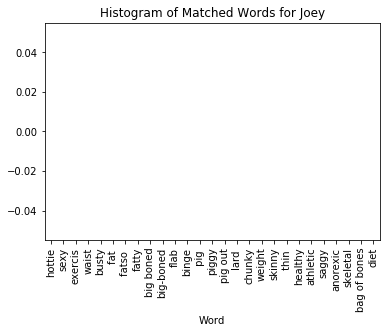

In [78]:
plot_basic_freq(Joey, "Joey")

# division by season

In [155]:
seasons = {"Season_"+ str(second_anchors.index(i)+1): i for i in second_anchors}
seasons["Season_3"]

[<a href="season/0301.html">301 The Princess Leia Fantasy </a>,
 <a href="season/0302.html">302 No One's Ready</a>,
 <a href="season/0303.html">303 The Jam</a>,
 <a href="season/0304.html">304 The Metaphorical Tunnel</a>,
 <a href="season/0305.html">305 Frank Jr.</a>,
 <a href="season/0306.html">306 The Flashback</a>,
 <a href="season/0307.html">307 The Race Car Bed</a>,
 <a href="season/0308.html">308 The Giant Poking Device</a>,
 <a href="season/0309.html">309 The Football</a>,
 <a href="season/0310.html">310 Rachel Quits</a>,
 <a href="season/0311.html">311 Chandler Can't Remember Which Sister</a>,
 <a href="season/0312.html">312 All The Jealousy</a>,
 <a href="season/0313.html">313 Monica And Richard Are Just Friends</a>,
 <a href="season/0314.html">314 Phoebe's Ex-Partner</a>,
 <a href="season/0315.html">315 Ross And Rachel Take A Break</a>,
 <a href="season/0316.html">316 The Morning After</a>,
 <a href="season/0317.html">317 The Ski Trip</a>,
 <a href="season/0318.html">318 The 

In [168]:
season_names = list(seasons.keys())
season_names

['Season_1',
 'Season_2',
 'Season_3',
 'Season_4',
 'Season_5',
 'Season_6',
 'Season_7',
 'Season_8',
 'Season_9',
 'Season_10']

In [171]:
season_links = {season: ["https://fangj.github.io/friends/" + i.get('href') for i in seasons[season]] for season in seasons}
season_links["Season_3"]

['https://fangj.github.io/friends/season/0301.html',
 'https://fangj.github.io/friends/season/0302.html',
 'https://fangj.github.io/friends/season/0303.html',
 'https://fangj.github.io/friends/season/0304.html',
 'https://fangj.github.io/friends/season/0305.html',
 'https://fangj.github.io/friends/season/0306.html',
 'https://fangj.github.io/friends/season/0307.html',
 'https://fangj.github.io/friends/season/0308.html',
 'https://fangj.github.io/friends/season/0309.html',
 'https://fangj.github.io/friends/season/0310.html',
 'https://fangj.github.io/friends/season/0311.html',
 'https://fangj.github.io/friends/season/0312.html',
 'https://fangj.github.io/friends/season/0313.html',
 'https://fangj.github.io/friends/season/0314.html',
 'https://fangj.github.io/friends/season/0315.html',
 'https://fangj.github.io/friends/season/0316.html',
 'https://fangj.github.io/friends/season/0317.html',
 'https://fangj.github.io/friends/season/0318.html',
 'https://fangj.github.io/friends/season/0319.

In [170]:
season_links["Season_3"]

['https://fangj.github.io/friends/season/0301.html',
 'https://fangj.github.io/friends/season/0302.html',
 'https://fangj.github.io/friends/season/0303.html',
 'https://fangj.github.io/friends/season/0304.html',
 'https://fangj.github.io/friends/season/0305.html',
 'https://fangj.github.io/friends/season/0306.html',
 'https://fangj.github.io/friends/season/0307.html',
 'https://fangj.github.io/friends/season/0308.html',
 'https://fangj.github.io/friends/season/0309.html',
 'https://fangj.github.io/friends/season/0310.html',
 'https://fangj.github.io/friends/season/0311.html',
 'https://fangj.github.io/friends/season/0312.html',
 'https://fangj.github.io/friends/season/0313.html',
 'https://fangj.github.io/friends/season/0314.html',
 'https://fangj.github.io/friends/season/0315.html',
 'https://fangj.github.io/friends/season/0316.html',
 'https://fangj.github.io/friends/season/0317.html',
 'https://fangj.github.io/friends/season/0318.html',
 'https://fangj.github.io/friends/season/0319.

In [172]:
season_htmls = {season: [requests.get(i) for i in season_links[season]] for season in seasons}
season_htmls["Season_3"]

[<Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>]

In [174]:
season_soups = {season: [BeautifulSoup(i.text, "html.parser") for i in season_htmls[season]] for season in seasons}
season_soups["Season_3"]

[<html>
 <head>
 <title>The One With the Princess Leia Fantasy</title>
 </head>
 <body alink="yellow" bgcolor="white" link="green" text="black" vlink="black">
 <h1 align="center">The One With the Princess Leia Fantasy</h1>
 <hr/>
 <i>
 <p></p></i>Written by: Michael Curtis and Gregory S. Malins<br/>
 Transcribed by: <a href="mailto:Ericaasen1@aol.com">Eric Aasen</a> </body></html>
 <hr/>
 <font size="3">
 <p align="left">[Scene Central Perk, the whole gang is entering]</p>
 <p><b>Joey:</b> I'm tellin' ya that girl totally winked at me.</p>
 <p><b>All:</b> Did not, she did not wink at you...(sees that their sacred couch is
 occupied by strangers).</p>
 <p><b>Chandler:</b> Huh. (They all leave, dejected)</p>
 <p align="center"><strong>Opening Credits</strong></p>
 <p>[Scene: Rachel and Monica's, Phoebe, Ross, and Rachel are eating breakfast.]</p>
 <p><b>Ross:</b> I have to say <em>Tupolo Honey</em> by Van Morrison.</p>
 <p><b>Rachel:</b> Nooo Way! The most romantic song ever is <em>The W

In [175]:
season_lines = {season: [i.find_all('font') for i in season_soups[season]] for season in seasons}
season_lines["Season_3"]

[[<font size="3">
  <p align="left">[Scene Central Perk, the whole gang is entering]</p>
  <p><b>Joey:</b> I'm tellin' ya that girl totally winked at me.</p>
  <p><b>All:</b> Did not, she did not wink at you...(sees that their sacred couch is
  occupied by strangers).</p>
  <p><b>Chandler:</b> Huh. (They all leave, dejected)</p>
  <p align="center"><strong>Opening Credits</strong></p>
  <p>[Scene: Rachel and Monica's, Phoebe, Ross, and Rachel are eating breakfast.]</p>
  <p><b>Ross:</b> I have to say <em>Tupolo Honey</em> by Van Morrison.</p>
  <p><b>Rachel:</b> Nooo Way! The most romantic song ever is <em>The Way We Were</em>.</p>
  <p><b>Phoebe:</b> See, I-I think that one that Elton John wrote for, um, that guy on <em>Who's
  The Boss</em>.</p>
  <p><b>Rachel:</b> What song was that, Pheebs?</p>
  <p><b>Phoebe:</b> (singing) <em>Hold me close, young Tony Dan-za</em>.</p>
  <p>(Monica enters from her bedroom)</p>
  <p><b>Phoebe:</b> Hi Monica!</p>
  <p><b>Ross:</b> Hey Mon!</p>
  <p>

In [178]:
season_flat_lines = {season: [item for sublist in season_lines[season] for item in sublist] for season in seasons}
season_flat_lines["Season_3"]

[<font size="3">
 <p align="left">[Scene Central Perk, the whole gang is entering]</p>
 <p><b>Joey:</b> I'm tellin' ya that girl totally winked at me.</p>
 <p><b>All:</b> Did not, she did not wink at you...(sees that their sacred couch is
 occupied by strangers).</p>
 <p><b>Chandler:</b> Huh. (They all leave, dejected)</p>
 <p align="center"><strong>Opening Credits</strong></p>
 <p>[Scene: Rachel and Monica's, Phoebe, Ross, and Rachel are eating breakfast.]</p>
 <p><b>Ross:</b> I have to say <em>Tupolo Honey</em> by Van Morrison.</p>
 <p><b>Rachel:</b> Nooo Way! The most romantic song ever is <em>The Way We Were</em>.</p>
 <p><b>Phoebe:</b> See, I-I think that one that Elton John wrote for, um, that guy on <em>Who's
 The Boss</em>.</p>
 <p><b>Rachel:</b> What song was that, Pheebs?</p>
 <p><b>Phoebe:</b> (singing) <em>Hold me close, young Tony Dan-za</em>.</p>
 <p>(Monica enters from her bedroom)</p>
 <p><b>Phoebe:</b> Hi Monica!</p>
 <p><b>Ross:</b> Hey Mon!</p>
 <p><b>Rachel:</b> Hey

In [179]:
season_list_script = {season: [i.get_text() for i in season_flat_lines[season]] for season in seasons}
season_list_script["Season_3"]

["\n[Scene Central Perk, the whole gang is entering]\nJoey: I'm tellin' ya that girl totally winked at me.\nAll: Did not, she did not wink at you...(sees that their sacred couch is\noccupied by strangers).\nChandler: Huh. (They all leave, dejected)\nOpening Credits\n[Scene: Rachel and Monica's, Phoebe, Ross, and Rachel are eating breakfast.]\nRoss: I have to say Tupolo Honey by Van Morrison.\nRachel: Nooo Way! The most romantic song ever is The Way We Were.\nPhoebe: See, I-I think that one that Elton John wrote for, um, that guy on Who's\nThe Boss.\nRachel: What song was that, Pheebs?\nPhoebe: (singing) Hold me close, young Tony Dan-za.\n(Monica enters from her bedroom)\nPhoebe: Hi Monica!\nRoss: Hey Mon!\nRachel: Hey Mon!\n(she just walks straight into the bathroom)\nPhoebe: Oh my God, has she slept at all?\nRoss: Nope.\nRachel: No, it's been three nights in a row.\nRoss: Yeah, she finally stopped crying yesterday, but then she found one of\nRichard's cigar butts out on the terrace, s

In [187]:
season_list_script["Season_3"][0]

"\n[Scene Central Perk, the whole gang is entering]\nJoey: I'm tellin' ya that girl totally winked at me.\nAll: Did not, she did not wink at you...(sees that their sacred couch is\noccupied by strangers).\nChandler: Huh. (They all leave, dejected)\nOpening Credits\n[Scene: Rachel and Monica's, Phoebe, Ross, and Rachel are eating breakfast.]\nRoss: I have to say Tupolo Honey by Van Morrison.\nRachel: Nooo Way! The most romantic song ever is The Way We Were.\nPhoebe: See, I-I think that one that Elton John wrote for, um, that guy on Who's\nThe Boss.\nRachel: What song was that, Pheebs?\nPhoebe: (singing) Hold me close, young Tony Dan-za.\n(Monica enters from her bedroom)\nPhoebe: Hi Monica!\nRoss: Hey Mon!\nRachel: Hey Mon!\n(she just walks straight into the bathroom)\nPhoebe: Oh my God, has she slept at all?\nRoss: Nope.\nRachel: No, it's been three nights in a row.\nRoss: Yeah, she finally stopped crying yesterday, but then she found one of\nRichard's cigar butts out on the terrace, so

For now leave it here - when doing season by season analyses, just treat the whole season as a huge block of text (should be fine) so just index it from dictionary, don't put it into dataframe - unless... 

In [180]:
# make ten different dfs - one for each season
df_Season_1 = pd.DataFrame(season_list_script["Season_1"], columns = ["Original Season 1"])
#df = pd.DataFrame(list_script, columns = ["Original"])
df_Season_1.head(10)

Original Season 1
0         \nWritten by: Marta Kauffman & David Crane
1                                               blue
2                                             text.)
3  \n[Scene: Central Perk, Chandler, Joey, Phoebe...
4  Monica: There's nothing to tell! He's just som...
5  Joey: C'mon, you're going out with the guy! Th...
6  Chandler: All right Joey, be\nnice.  So does h...
7                        All right Joey, be\nnice.  
8                   Phoebe: Wait, does he eat chalk?
9                         (They all stare, bemused.)